# Exercise 1b

## Fundamentals of Machine Learning

#### Author: Elias Olofsson

#### Version information:
        2020-11-27: v.1.0. First public release. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time

## Exercise 3 - Nearest Neighbor Classification on Real Data

### 3.1 - Exploring the Data (3 pts)

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

print(data.dtype)
print(data.shape)
print(images.shape)
print(images[3].shape)
print(target.shape)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64
(1797, 64)
(1797, 8, 8)
(8, 8)
(1797,)


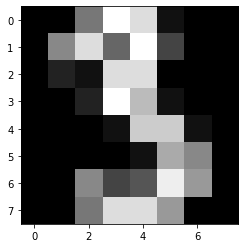

In [3]:
img = images[3]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img,interpolation="nearest",) # also try interpolation="bicubic"
plt.show()

In [4]:
from sklearn import model_selection

X_all = data
y_all = target

X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data,digits.target,test_size=0.4,random_state=0)

### 3.2 - Distance function computation using loops (3 pts) 

In [5]:
def dist_loops(training, test):
    """
    Calculate the euclidean distances between all instances in the training and the test sets
    in the feature space, using for-loops.
    
    params
    ------
    training: np.array
        Matrix of size (N,D), where N number of instances, D number of pixels in each image.
    test: np.array
        Matrix of size (M,D), where M number of instances, D number of pixels in each image.

    returns
    -------
    np.array shape=(N,M)
        Euclidean distances from each training instance to each test instance.
    """
    # Find sizes of matrices.
    N,D1 = training.shape
    M,D2 = test.shape

    # Assure that sizes match.
    assert D1 == D2
    D = D1

    # Preallocation
    dist = np.zeros((M,N))
    
    # for each image in test set
    for i in range(M):
        # for each image in training set
        for j in range(N): 
            # for each pixel in image, calculate the euclidean distance.
            d = 0
            for k in range(D): 
                d = d + (test[i,k]-training[j,k])**2
            d = np.sqrt(d)
            # Put value in distance matrix
            dist[i,j] = d
    return dist

### 3.3 - Distance function computation using vectorization (8 pts)

In [6]:
def dist_vec(training, test):
    """
    Calculate the euclidean distances between all instances in the training and the test sets
    in the feature space, using vectorization.
    
    params
    ------
    training: np.array
        Matrix of size (N,D), where N number of instances, D number of pixels in each image.
    test: np.array
        Matrix of size (M,D), where M number of instances, D number of pixels in each image.

    returns
    -------
    np.array shape=(N,M)
        Euclidean distances from each training instance to each test instance.
    """
    # Find the sizes of the matrices.
    N,D1 = training.shape
    M,D2 = test.shape

    # Assure that the sizes along the D-axis match.
    assert D1 == D2
    D = D1
    
    # Stack N or M clones of each 2d matrix into the third dimension.
    training_3d = np.tile(training,(M,1,1))     # 3d-matrix with dimensions (M,N,D)
    test_3d = np.tile(test, (N,1,1))            # 3d-matrix with dimensions (N,M,D)

    # Swap axes so dimensions match (M,N,D)
    test_3d = np.swapaxes(test_3d,0,1)

    # Subtract the two 3d matricies elementwise, square elementwise, sum along the D-axis and  
    # finish with the elementwise square root. Thus we have the euclidian distance matrix.
    dist = np.sqrt(np.sum((test_3d-training_3d)**2, axis=2))          

    return dist

In [7]:
# Time the executions for both functions, and assure that both produce the same result.
tik = time.time()
A1 = dist_loops(X_train,X_test)
tok = time.time()
print(f"Time elapsed for dist_loops(): {tok-tik:.2f} s")

tik = time.time()
A2 = dist_vec(X_train,X_test)
tok = time.time()
print(f"Time elapsed for dist_vec(): {tok-tik:.2f} s")

assert np.array_equal(A1,A2)

Time elapsed for dist_loops(): 38.52 s
Time elapsed for dist_vec(): 0.37 s


### 3.4 - Implementation of the k-nearest neighbor classifier

In [8]:
def kNN_classifier(X_training, X_test, y_training, k, dist_func):
    """
    Classify M test instances X using the k-nearest neighbors algorithm, given a training set with N
    instances of feature data X in D dimensions and N corresponding labels y.

    params
    ------
    X_training: np.array
        Matrix of size (N,D), where N number of training instances, D number of pixels in 
        each image.
    X_test: np.array
        Matrix of size (M,D), where M number of test instances, D number of pixels in each image.
    y_training: np.array
        Matrix of size (N,1) with labels corresponding to the instances in X_training.
    k: int
        Number of neighbors to include in the majority vote for classification.
    dist_func: callable
        Function to calculate distances between all instances in the test and training sets.  

    returns
    -------
    np.array shape=(M,1)
        Predictions for every instance in test set, given the training set.
    """

    # Get the distance matrix.
    dist = dist_func(X_training, X_test)        # shape (M,N)

    # Get indicies of the k smallest distances for each test instance.
    ind = np.argpartition(dist, k, axis=1)[:,:k]  # shape (M,k)
    
    # Preallocation
    M = X_test.shape[0]
    y_prediction = np.zeros(M)

    # For each test instance, get the most frequently occuring label. Choose 
    # this as our prediction y.
    for i in range(M):
        y_prediction[i] = np.bincount(y_training[ind[i,:]]).argmax()

    return y_prediction

Use the classifier to distinguish digits of 3 from digits of 9.

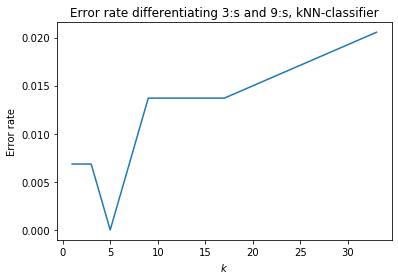

In [10]:
# Filter out threes and nines from the training and test data.
mask = (target == 3) | (target == 9)
data_filtered   = data[mask,:]
target_filtered = target[mask]

# Create training and test sets.
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_filtered,target_filtered,test_size=0.4,random_state=0)

# k-values to test.
k_list = [1,3,5,9,17,33]
error = np.zeros(len(k_list))
for i,k in enumerate(k_list):
    # Get prediction.
    y_predict = kNN_classifier(X_train, X_test, y_train, k, dist_vec)

    # Calculate error rate.
    correct_pred = sum(y_test == y_predict)
    error[i] = 1 - correct_pred/len(y_test)

# Plot error rate as function of k.
plt.plot(k_list, error)
plt.xlabel('$k$')
plt.ylabel('Error rate')
plt.title('Error rate differentiating 3:s and 9:s, kNN-classifier')
plt.show()

## Exercise 4 - Cross-validation